In [ ]:
import numpy as np
import pandas as pd

/kaggle/input/mlp-term-2-2025-kaggle-assignment-1/sample_submission.csv
/kaggle/input/mlp-term-2-2025-kaggle-assignment-1/train.csv
/kaggle/input/mlp-term-2-2025-kaggle-assignment-1/test.csv


In [ ]:
# Load the data
train = pd.read_csv('/kaggle/input/mlp-term-2-2025-kaggle-assignment-1/train.csv')
test = pd.read_csv('/kaggle/input/mlp-term-2-2025-kaggle-assignment-1/test.csv')
# Show basic info
print("Train shape:", train.shape)
print("Test shape:", test.shape)
train.head()

Train shape: (40000, 12)
Test shape: (10000, 11)


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,airline,flight,source,departure,stops,arrival,destination,class,duration,days_left,price
0,0,Vistara,UK-930,Mumbai,Early_Morning,one,Night,Chennai,Business,NaN,40.0,64173
1,1,Air_India,AI-539,Chennai,Evening,one,Morning,Mumbai,Economy,16.08,26.0,4357
2,2,SpiceJet,SG-8107,Delhi,Early_Morning,zero,Morning,Chennai,Economy,2.92,25.0,3251
3,3,NaN,0.00E+00,Hyderabad,Early_Morning,zero,Morning,Bangalore,Economy,1.50,22.0,1776
4,4,Air_India,AI-569,Chennai,Early_Morning,one,Morning,Bangalore,Economy,4.83,20.0,3584


In [ ]:
#MISSING VALUES
print("train:\n",train.isnull().sum())
print("\n")
print("TesT:\n",test.isnull().sum())

train:
 id                0
airline        4613
flight            0
source            0
departure      4792
stops          2319
arrival           0
destination       0
class             0
duration       3013
days_left      4438
price             0
dtype: int64


TesT:
 id               0
airline        548
flight           0
source           0
departure      920
stops          651
arrival          0
destination      0
class            0
duration       582
days_left      696
dtype: int64


In [ ]:
#DUPLICATES
print("Train Duplicates:", train.duplicated().sum())
train = train.drop_duplicates()
print("Test Duplicates:", test.duplicated().sum())
test = test.drop_duplicates()

Train Duplicates: 0
Test Duplicates: 0


In [ ]:
# Separate numeric columns without 'price' for test set
num_cols = train.select_dtypes(include=['int64', 'float64']).columns.tolist()
test_num_cols = [col for col in num_cols if col != 'price']
# Impute train
for col in num_cols:
    train[col].fillna(train[col].mean(), inplace=True)
# Impute test
for col in test_num_cols:
    test[col].fillna(test[col].mean(), inplace=True)

/tmp/ipykernel_13/3553844085.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train[col].fillna(train[col].mean(), inplace=True)
/tmp/ipykernel_13/3553844085.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

In [ ]:
def remove_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[col] >= lower) & (df[col] <= upper)]
# Apply on price and duration
train = remove_outliers_iqr(train, 'price')
train = remove_outliers_iqr(train, 'duration')

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


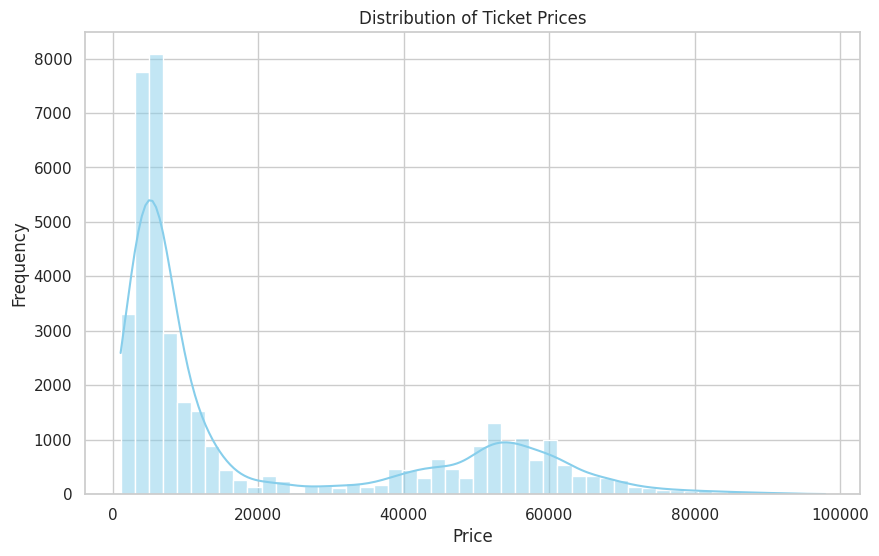

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(train['price'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Ticket Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

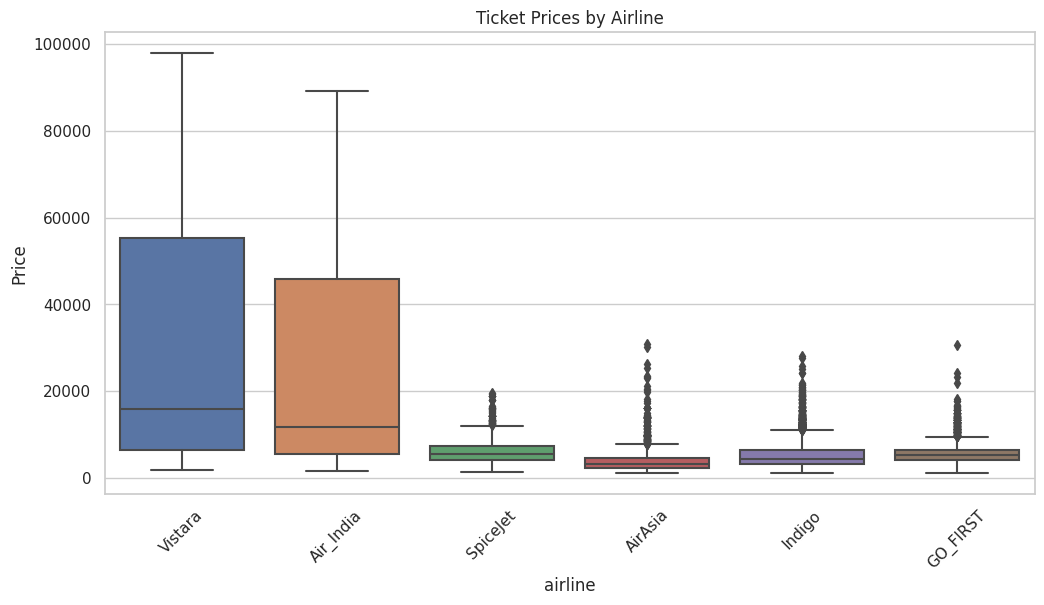

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='airline', y='price', data=train)
plt.xticks(rotation=45)
plt.title('Ticket Prices by Airline')
plt.ylabel('Price')
plt.show()

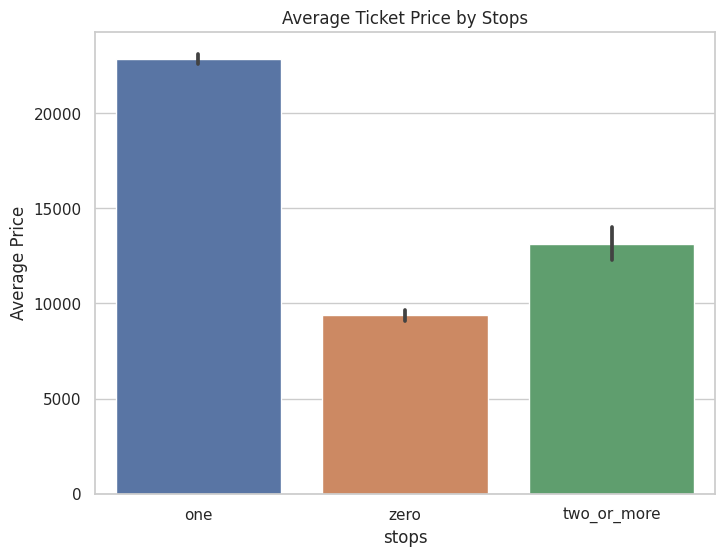

In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot(x='stops', y='price', data=train, estimator='mean')
plt.title('Average Ticket Price by Stops')
plt.ylabel('Average Price')
plt.show()

In [ ]:
#Split Features and Target
X = train.drop(columns=['price'])  # features
y = train['price']                # target
# Identify Columns to Transform
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [ ]:
#Define Preprocessing Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
# Numerical pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])
# Categorical pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
# Combine
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)])

In [ ]:
#Train/Test Split
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
models = {
    "LinearRegression": LinearRegression(),
    "KNN": KNeighborsRegressor(),
    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "RandomForest": RandomForestRegressor(random_state=42),
    }
results = {}
for name, model in models.items():
    pipe = make_pipeline(preprocessor, model)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_val)
    r2 = r2_score(y_val, y_pred)
    results[name] = r2
    print(f"{name}: R2 Score = {r2:.2f}")

LinearRegression: R2 Score = 0.92
KNN: R2 Score = 0.89
DecisionTree: R2 Score = 0.96
RandomForest: R2 Score = 0.98
GradientBoosting: R2 Score = 0.95
AdaBoost: R2 Score = 0.93
SVR: R2 Score = -0.30


In [ ]:
from sklearn.model_selection import GridSearchCV
# Reuse this pipeline structure
from sklearn.pipeline import Pipeline

#Random Forest Regressor

from sklearn.ensemble import RandomForestRegressor
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))])
rf_params = {
    'model__n_estimators': [50, 100],
    'model__max_depth': [10, 20]}
rf_grid = GridSearchCV(rf_pipeline, rf_params, cv=3, scoring='r2', n_jobs=-1)
rf_grid.fit(X_train, y_train)
print("Best RF Params:", rf_grid.best_params_)
print("RF R²:", round(rf_grid.score(X_val, y_val), 2))

Best RF Params: {'model__max_depth': 20, 'model__n_estimators': 100}
RF R²: 0.98
Best Decision Tree Params: {'model__max_depth': 30, 'model__min_samples_split': 10}
Decision Tree R²: 0.97
Best GB Params: {'model__learning_rate': 0.1, 'model__n_estimators': 100}
GB R²: 0.95


In [ ]:
# Use best tuned Random Forest model
best_rf_model = rf_grid.best_estimator_
# Predict on test set
test_predictions = best_rf_model.predict(test)
# Load sample submission
sample_submission = pd.read_csv('/kaggle/input/mlp-term-2-2025-kaggle-assignment-1/sample_submission.csv')
# Create submission file
submission = pd.DataFrame({
    'id': sample_submission['id'],
    'price': test_predictions})
# Save to CSV
submission.to_csv('submission.csv', index=False)
print("Submission file 'submission.csv' saved successfully!")

Submission file 'submission.csv' saved successfully!
